In [1]:
%matplotlib inline
import numpy as np
import scipy.signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.autograd import Variable
import time
from time import strftime, localtime
import copy

# Datasets

Set 1: mixture of randomly generated sines and sine-gaussians within sensible parameters ranges and NO noise.

## Training

- 100 mixed signals + clean/target sources signals

In [42]:
# Parameters

N = 1000
fs = 100
T = N / fs
t = np.linspace(0,T,N)

# These vary..

freq_sin = np.random.uniform(0.0, 10.0, 100)
phase_shift_sin = np.random.uniform(0.0, 2.0*np.pi, 100)
t0_sg = np.random.uniform(0.0, T, 100)

# These are fixed

a = 0.1
phi0 = np.pi
f0 = 2.0
tau = 0.5

In [43]:
# Time Series

s_train = np.zeros((100,N))
sg_train = np.zeros((100,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(100):
    
    s_train[i,:] = a*np.sin(2*np.pi*freq_sin[i]*t + phase_shift_sin[i]) #+ noise
    sg_train[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    mix_train = s_train + sg_train

(100, 1000)
(100, 1000)
(1000,)


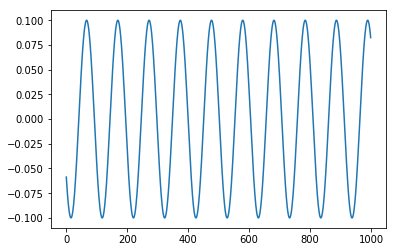

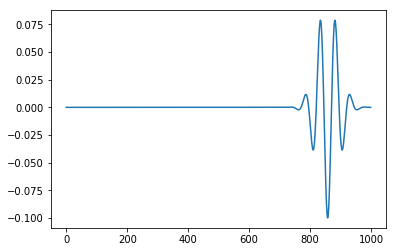

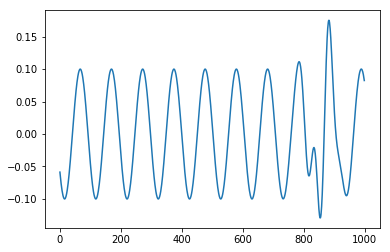

In [44]:
print(s_train.shape)
print(sg_train.shape)
print (mix_train[0].shape)

plt.plot(s_train[0,:])
plt.show()
plt.plot(sg_train[0,:])
plt.show()
plt.plot(mix_train[0,:])
plt.show()

/home/annaf/anaconda3/lib/python3.6/site-packages/matplotlib/mlab.py:1274: UserWarning: Only one segment is calculated since parameter NFFT (=1000) >= signal length (=1000).
  "(=%d) >= signal length (=%d)." % (NFFT, len(x)))


Text(0.5,1,'Sine wave spectrogram')

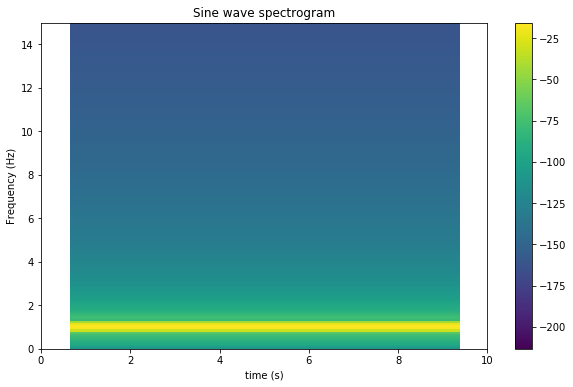

In [51]:
# Spectrograms

# pick a short FTT time interval, like 1/8 of a second:
NFFT = int(fs/0.1)
# and with a lot of overlap, to resolve short-time features:
NOVL = 128 #int(NFFT*15./16)
# and choose a window that minimizes "spectral leakage" 
window = np.blackman(NFFT)
# colormap 
spec_cmap='viridis'

# Plot the sine spectrogram:
plt.figure(figsize=(10,6))
spec_s, freqs, bins, im = plt.specgram(s_train[0,:], NFFT=NFFT, Fs=fs, window=window, 
                                       noverlap=NOVL, cmap=spec_cmap)
plt.xlabel('time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([0.0, 10.0, 0.0, 15.0])
plt.title('Sine wave spectrogram')

/home/annaf/anaconda3/lib/python3.6/site-packages/matplotlib/mlab.py:1274: UserWarning: Only one segment is calculated since parameter NFFT (=1000) >= signal length (=1000).
  "(=%d) >= signal length (=%d)." % (NFFT, len(x)))


Text(0.5,1,'Sine-gaussian spectrogram')

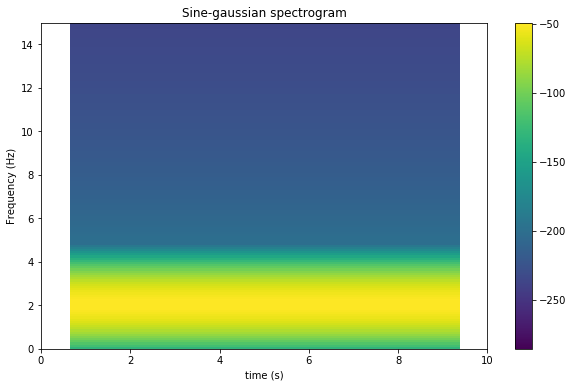

In [52]:
# Plot the sine-gaussian spectrogram:
plt.figure(figsize=(10,6))
spec_s, freqs, bins, im = plt.specgram(sg_train[0,:], NFFT=NFFT, Fs=fs, window=window, 
                                       noverlap=NOVL, cmap=spec_cmap)
plt.xlabel('time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([0.0, 10.0, 0.0, 15.0])
plt.title('Sine-gaussian spectrogram')

/home/annaf/anaconda3/lib/python3.6/site-packages/matplotlib/mlab.py:1274: UserWarning: Only one segment is calculated since parameter NFFT (=1000) >= signal length (=1000).
  "(=%d) >= signal length (=%d)." % (NFFT, len(x)))


Text(0.5,1,'Sine wave spectrogram')

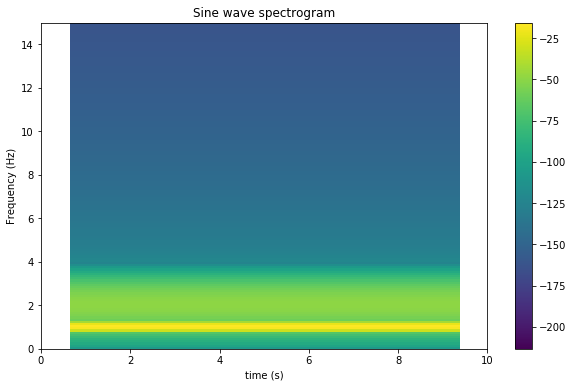

In [53]:
# Plot the sine spectrogram:
plt.figure(figsize=(10,6))
spec_s, freqs, bins, im = plt.specgram(mix_train[0,:], NFFT=NFFT, Fs=fs, window=window, 
                                       noverlap=NOVL, cmap=spec_cmap)
plt.xlabel('time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([0.0, 10.0, 0.0, 15.0])
plt.title('Sine wave spectrogram')

## Validation

- 20 mixed signals + clean/target sources signals

In [10]:
# Same as training 

s_validation = np.zeros((20,N))
sg_validation = np.zeros((20,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(20):
    
    s_validation[i,:] = a*np.sin(2*np.pi*t + phase_shift_sin[i]) #+ noise
    sg_validation[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    mix_validation = s_validation + sg_validation

## Testing

- 100 randomly generated useen mixed signals + clean/target sources for evaluation

In [24]:
# Time series

s_test = np.zeros((100,N))
sg_test = np.zeros((100,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(100):
    
    s_test[i,:] = a*np.sin(2*np.pi*t + phase_shift_sin[i]) #+ noise
    sg_test[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    mix_test = s_test + sg_test

In [12]:
# Spectrograms

# Model

- Architecture is the same for each source. One net per source.
- Basically a convolutional AE
- Loss function is the mean square error between the output and the clean target.
- Weights initiated randomly

In [7]:
# Time Series

class CDAE(nn.Module):
    
    def __init__(self, in_dim=1000):
        super(CDAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(in_dim, in_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(5, stride=1, return_indices=True),
            nn.Conv1d(200, 200, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(5, stride=1, return_indices=True),
            nn.Conv1d(40, 40, stride=1, padding=1)
            
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(40, 40, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxUnpool1d(5, stride=1)
            nn.ConvTranspose1d(200, 200, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxUnpool1d(5, stride=1)
            nn.ConvTranspose1d(in_dim, in_dim, stride=1, padding=1),
            nn.ReLU(),
        )
        
    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        return x   

In [ ]:
# Spectrograms